In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pystan
pd.options.display.max_columns = None

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')

# Import data
# observed data
df = pd.read_csv('../data/HtWt.csv')
df.head()

,male,height,weight,group
0,0,63.2,168.7,A
1,0,68.7,169.8,A
2,0,64.8,176.6,A
3,0,67.9,246.8,A
4,1,68.9,151.6,A


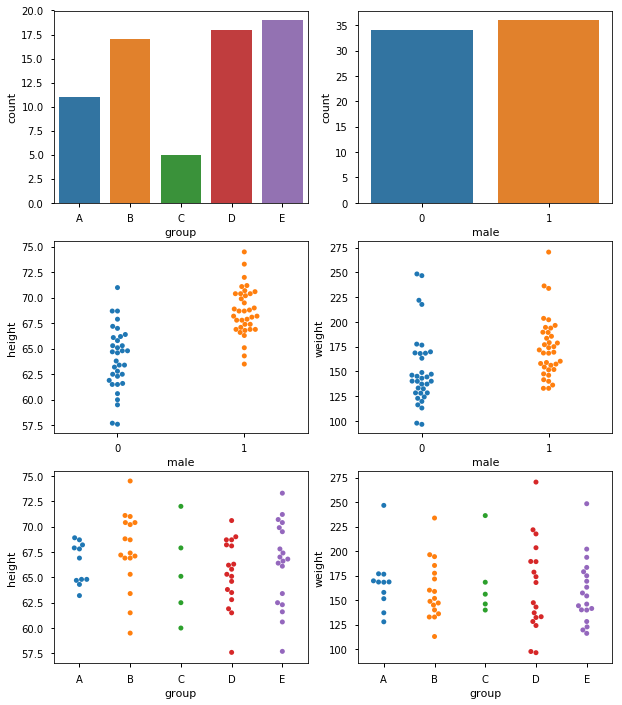

In [17]:
# basic data exploratory tasks
fig, axarr  = plt.subplots(3, 2, figsize=(10,12),)
sns.countplot(x='group', data=df, ax=axarr[0,0], order=['A','B','C', 'D', 'E'])
sns.countplot(x='male', data=df, ax=axarr[0,1],  order=[0,1])

# show distributions of data in the groups
sns.swarmplot(x='male', y='height', data=df, ax=axarr[1,0])
sns.swarmplot(x='male', y='weight', data=df, ax=axarr[1,1])

sns.swarmplot(x='group', y='height', data=df, ax=axarr[2,0])
sns.swarmplot(x='group', y='weight', data=df, ax=axarr[2,1])

In [34]:
# make dummies variables
# https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python
df_dm = pd.get_dummies(df['group'])
print( df_dm.index, df.index )

# merge back into the original dataset
df = pd.merge(df, df_dm, left_index=True,right_index=True)
df

(RangeIndex(start=0, stop=70, step=1), RangeIndex(start=0, stop=70, step=1))


,male,height,weight,group,A,B,C,D,E
0,0,63.2,168.7,A,1,0,0,0,0
1,0,68.7,169.8,A,1,0,0,0,0
2,0,64.8,176.6,A,1,0,0,0,0
3,0,67.9,246.8,A,1,0,0,0,0
4,1,68.9,151.6,A,1,0,0,0,0
5,1,67.8,158.0,A,1,0,0,0,0
6,1,68.2,168.6,A,1,0,0,0,0
7,0,64.8,137.2,A,1,0,0,0,0
8,1,64.3,177.0,A,1,0,0,0,0
9,0,64.7,128.0,A,1,0,0,0,0


In [18]:
# Now, how do I fit a hierachical model in STAN with these information?
log_reg_code = """
data {
    int<lower=0> n;
    int male[n];
    real weight[n];
    real height[n];
}
transformed data {}
parameters {
    real a;
    real b;
    real c;
}
transformed parameters {}
model {
    a ~ normal(0, 10);
    b ~ normal(0, 10);
    c ~ normal(0, 10);
    for(i in 1:n) {
        male[i] ~ bernoulli(inv_logit(a*height[i] + b*weight[i] + c));
  }
}
generated quantities {}
"""

log_reg_dat = {
             'n': len(df),
             'male': df.male,
             'height': df.height,
             'weight': df.weight
            }

fit = pystan.stan(model_code=log_reg_code, data=log_reg_dat, 
                  iter=400, chains=4)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b8ed55c179bbc8d203ec8882b06f6604 NOW.
/Users/cuongnguyen/miniconda2/envs/stan27/lib/python2.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [19]:
print fit


Inference for Stan model: anon_model_b8ed55c179bbc8d203ec8882b06f6604.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a      0.38  2.6e-3   0.09   0.21   0.32   0.38   0.44   0.57 1245.0    1.0
b    9.3e-3  2.3e-4 9.1e-3-8.7e-3 3.1e-3 8.8e-3   0.02   0.03 1538.0    1.0
c    -26.77    0.16    5.8 -38.56 -30.51 -26.76 -22.86 -15.83 1273.0    1.0
lp__ -35.29    0.03   1.21 -38.51 -35.81 -34.99 -34.41  -33.9 1226.0    1.0

Samples were drawn using NUTS at Sun Jul 15 21:06:05 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


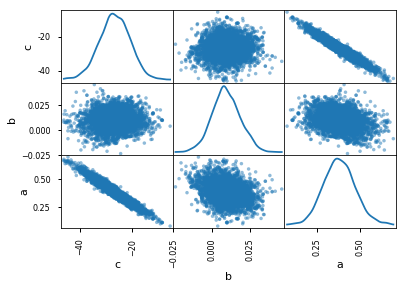

In [20]:
df_trace = pd.DataFrame(fit.extract(['c', 'b', 'a']))
pd.plotting.scatter_matrix(df_trace[:], diagonal='kde');


In [36]:
# now we can squash features into a Matrix form

log_reg_model_m = """data {
    // number of observations
    int<lower=0> n;
    
    // target vector
    int male[n];
    
    // number of predictors
    int k;
    
    // features matrix
    matrix[n, k] X;
}
transformed data {

}
parameters {
 // regression coefficient vector
  vector[k] b;
  real c;
  // scale of the regression errors
  // real<lower = 0.0> sigma;

  // real b_loc;
  // real<lower = 0.0> b_scale;
  
//    vector[k] mu_b;
//    cov_matrix[k] Sigma_b;
}
transformed parameters {
    // row_vector[k] b_r;
    // b_r = to_row_matrix(b);
    // mu is the observation fitted/predicted value also called yhat
    vector[n] mu;
    mu = X * b;
}
model {    
    // Multivariate normal distribution parameters
    for (j in 1:k){
        b[j] ~ normal(0, 10);
    }
        
    c ~ normal(0, 10);
    for(i in 1:n) {
        male[i] ~ bernoulli(inv_logit(mu[i] + c));
  }
}
generated quantities {}
"""

# precompile the model object here
sm = pystan.StanModel(model_code=log_reg_model_m)



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_47b5518b8ae26f1534e3bf56243f8b46 NOW.


In [37]:
# now make the data
log_reg_dat_matrix = {
             'n': len(df),
             'male': df.male,
             'k': 7,
             'X': df[ ['height', 'weight', 'A', 'B', 'C', 'D', 'E'] ].values ,
            }
# fit2 = pystan.stan( model_code=log_reg_model_m, data=log_reg_dat_matrix, 
#                     iter=1000, chains=2)


In [75]:
df.male

0     0
1     0
2     0
3     0
4     1
5     1
6     1
7     0
8     1
9     0
10    1
11    1
12    1
13    1
14    1
15    1
16    0
17    1
18    0
19    1
20    0
21    1
22    0
23    1
24    0
25    1
26    0
27    1
28    0
29    0
     ..
40    0
41    0
42    0
43    1
44    0
45    0
46    0
47    1
48    0
49    1
50    1
51    0
52    1
53    1
54    0
55    1
56    1
57    0
58    1
59    0
60    1
61    1
62    0
63    0
64    1
65    0
66    1
67    0
68    0
69    1
Name: male, Length: 70, dtype: int64

In [38]:
# fit the data using the precompiled model object
fit2 = sm.sampling(data=log_reg_dat_matrix, iter=1000, chains=2)

((1000, 7), (1000, 1))


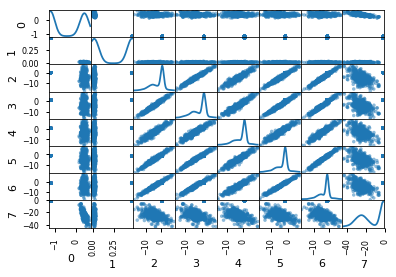

In [39]:
# print(fit2)
type(fit2)
fit2_sample = fit2.extract(permuted=True) # of type OrderedDict
print(fit2_sample['b'].shape, np.expand_dims(fit2_sample['c'],axis=1).shape)
ar_trace = np.concatenate([fit2_sample['b'], np.expand_dims(fit2_sample['c'], axis=1)], axis=1)
df_trace2 = pd.DataFrame(ar_trace)
pd.plotting.scatter_matrix(df_trace2[:], diagonal='kde');

In [49]:
# Now how do I fit a hierarchical logistic model here?
# check section 9.9 in the STAN manual for instructions
hier_log_reg_model = """data {
    // number of observations
    int<lower=0> N;
    
    // number of level
    int<lower=1> L;
    
    // target vector - equivalent to y[N] in the Manual
    int male[N];
    
    // number of predictors - equivalent to D in the Manual
    int K;
    
    // features matrix
    matrix[N, K] X;
    
    // what is ll? actual vector of ll
    int<lower=1, upper=L> ll[N];
}
transformed data {
}
parameters {
  // regression coefficient vector
  real mu[K];
  real<lower=0> sigma[K];  
  vector[K] beta[L];
}

model {    
    for (d in 1:K){
        mu[d] ~ normal(0, 100);
        for (l in 1:L){
            beta[l, d] ~ normal(mu[d], sigma[d]);
        }
    }
    
    for(n in 1:N) {
        male[n] ~ bernoulli(inv_logit(X[n] * beta[ll[n]]));
  }
}
"""

# precompile the model object here
sm_hier_lr = pystan.StanModel(model_code=hier_log_reg_model)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2df4a199d22b82c41cb7c301c7a08154 NOW.


In [43]:

# make a new column to map the groups from ABCD to 0,1,2,3
dgroups = df.group.unique()
glookup = dict(zip(dgroups, range(len(dgroups))))
glookup

groups = df['group_code'] = df.group.replace(glookup).values # make a new column for county code

In [58]:
# now make the data
hier_log_reg_dat = {
            'N': len(df),
            'male': df.male,
            'll': groups + 1,
            'L': len(glookup),
            'K': 2,
            'X': df[ ['height', 'weight'] ].values,
}
# fit2 = pystan.stan( model_code=log_reg_model_m, data=log_reg_dat_matrix, 
#                     iter=1000, chains=2)


In [59]:
# fit the data using the precompiled model object
fit3 = sm_hier_lr.sampling(data=hier_log_reg_dat, iter=1000, chains=2)

In [ ]:
# print(fit2)
type(fit2)
fit3_sample = fit3.extract(permuted=True) # of type OrderedDict

In [68]:
# try to print model trace here
print(fit3_sample['beta'].shape)
ar_trace3 = fit3_sample['beta']
# df_trace3 = pd.DataFrame(ar_trace3)
# pd.plotting.scatter_matrix(df_trace3[:], diagonal='kde');

(1000, 5, 2)


In [ ]:
# show sample by groups here
# Plot the orbital period with horizontal boxes
plt.figure(figsize=(16, 6))
sns.boxplot(data=fit3_sample, whis=np.inf, color="c")

In [65]:
fit3_sample['beta'].shape # (1000, 5, 2)

(1000, 5, 2)

In [74]:
print(fit3_sample['mu'].shape, fit3_sample['sigma'].shape, fit3_sample['beta'].shape)


((1000, 2), (1000, 2), (1000, 5, 2))


In [72]:
fit3_sample

OrderedDict([(u'mu', array([[-0.07601721,  0.04250405],
                     [-0.03766685,  0.00777814],
                     [-0.04428125,  0.01932816],
                     ...,
                     [-0.04147881,  0.00748445],
                     [-0.04406386,  0.0160724 ],
                     [-0.00540295,  0.01173427]])),
             (u'sigma', array([[0.00578891, 0.00706444],
                     [0.03149725, 0.00125828],
                     [0.00682014, 0.00062503],
                     ...,
                     [0.03652714, 0.01163321],
                     [0.07199417, 0.01692853],
                     [0.05783967, 0.02754835]])),
             (u'beta', array([[[-0.07722649,  0.03025096],
                      [-0.07111421,  0.03578586],
                      [-0.07432866,  0.03931475],
                      [-0.07570213,  0.02685848],
                      [-0.07006437,  0.02695593]],
              
                     [[-0.03552427,  0.01048996],
                      [-